## NEURAL STYLE TRANSFER

## BY MOTOLANI AKINGBADE AND EMMANUEL ITSUOKOR

#### NEURAL TRANSFER IS A CAPTIVATING EXPERIENCE BETWEEN ARTIFICIAL INTELLIGENCE AND ARTISTIC CREATIVITY. THIS TECHNOLOGY LEVERAGES THE CAPABILITIES OF DEEP LEARNING TO MERGE THE ESSENCE OF ONE IMAGE WITH THE AESTHETIC STYLE OF ANOTHER. IT WORKS WITH TAKING TWO IMAGES, A CONTENT IMAGE (LIKE A PHOTOGRAPH) AND A STYLE IMAGE, MORE LIKE A FAMOUS PAINTING, AND COMBINING THEM. 
#### The goal is to produce a new image that retains the original content but is rendered in the artistic style of the second image.




## Problem Statement
This project's goal is to create and assess machine learning methods for picture processing and analysis. The assignment entails investigating importing, preprocessing, and visualising picture data using TensorFlow and TensorFlow Hub. This could involve applying transformations, converting image tensors to visual representations, and using pre-trained models for tasks like object detection, style transfer, and image classification.

## Importing Libaries

In [157]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import tensorflow_hub as hub

import numpy as np
import PIL.Image
import time
import functools
from IPython import display

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Data Collection and Preprocessing

In [158]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [159]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

An image is loaded and preprocessed for machine learning tasks using the load_img function. It reads the image file, decodes it into a 3-channel tensor, resizes it to 512 pixels at most while maintaining the aspect ratio, and normalises pixel values to the range [0, 1]. In order to guarantee that the image is prepared for input into machine learning models or additional analysis, it lastly adds a batch dimension.

In [160]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

Matplotlib's imshow function is a tool for presenting images. It uses tf.squeeze to eliminate any batch dimensions from the input image. After that, plt.imshow is used to display the image, and plt.title can be used to optionally add a title. During analysis or debugging, this feature makes it easier to visualise processed or model-generated images.

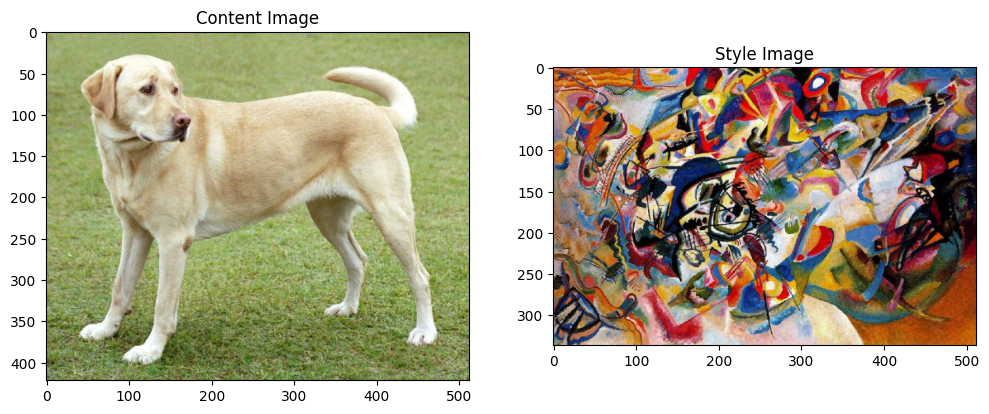

In [161]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Model selection and Integration

### Testing out pre-trained model from tensor flow

#### this takes the content image and style image then outputs a single image with the content image and style image blended together. The model does not require further training, making it suitable for real-time applications.  It is deployed with tensorflow lite.
#### Advantages of Fast Style Transfer:
#### Speed: Real-time or near real-time performance.
#### Pre-trained Models: No need to train from scratch; you can use models optimized for various styles.


#### The code applies neural style transfer using a pre-trained model. It loads and resizes a content image and a style image to 256x256 pixels, normalizes their pixel values to [0, 1], and adds a batch dimension for processing. The pre-trained model combines the content and style images to create a stylized version of the content image. The output is simplified to remove the batch dimension, resulting in a stylized image ready for display or further use.

In [162]:

content_image = tf.io.read_file(content_path)
content_image = tf.image.decode_jpeg(content_image, channels=3)
content_image = tf.image.resize(content_image, (256, 256))

style_image = tf.io.read_file(style_path)
style_image = tf.image.decode_jpeg(style_image, channels=3)
style_image = tf.image.resize(style_image, (256, 256)) 


content_image = tf.expand_dims(content_image, axis=0)  
style_image = tf.expand_dims(style_image, axis=0)    


content_image = content_image / 255.0
style_image = style_image / 255.0

model_path = '/Users/elder/Desktop/nst/arbitrary-image-stylization-v1-tensorflow1-256-v2'
hub_model = hub.load(model_path)


stylized_image = hub_model(content_image, style_image)[0]

stylized_image = tf.squeeze(stylized_image, axis=0)




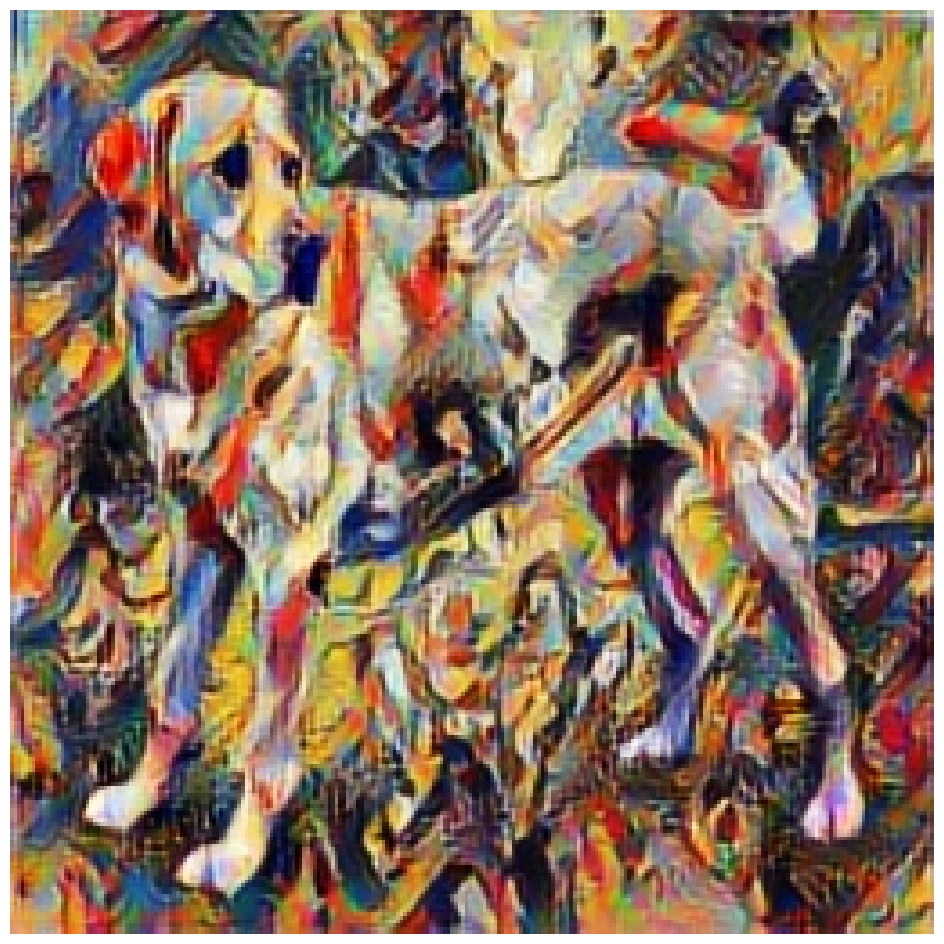

In [163]:
def tensor_to_image(tensor):
    tensor = tensor * 255 
    tensor = tf.cast(tensor, tf.uint8)
    
    if len(tensor.shape) == 4:  
        tensor = tf.squeeze(tensor, axis=0)

    return tf.image.encode_jpeg(tensor)


stylized_image = tensor_to_image(stylized_image)

plt.imshow(tf.image.decode_jpeg(stylized_image).numpy())
plt.axis('off')
plt.show()

The purpose of the tensor_to_image function is to transform a TensorFlow tensor into an image format that can be understood visually. It handles situations when the tensor has more than three dimensions by extracting the first image in the batch, scales the tensor values from the range [0, 1] to [0, 255], and then transforms the scaled tensor into a NumPy array of 8-bit unsigned integers. The processed array is then converted into a PIL picture, suitable for visualisation.

### Custom model and working with VGG19

#### DEFINING CONTENT AND STYLE REPRESENTATION
#### Content Representation
#### Purpose: Captures the structural elements and spatial layout of an image, such as objects, their shapes, and their arrangements.
 #### Style Representation
#### Purpose: Encodes the artistic patterns, textures, and overall "look and feel" of an image, such as brush strokes, color palettes, and repetitive patterns.
#### How It Works:
#### Style is represented using the Gram matrix of feature maps from multiple layers of the CNN. 



In [164]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [165]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', np.float32(0.457799)),
 ('golden_retriever', np.float32(0.23333368)),
 ('kuvasz', np.float32(0.054171182)),
 ('Chesapeake_Bay_retriever', np.float32(0.027302803)),
 ('Greater_Swiss_Mountain_dog', np.float32(0.019838905))]

The code preprocesses and resizes an image to match VGG19's input requirements, loads the pre-trained VGG19 model with ImageNet weights, and predicts class probabilities. It then decodes the predictions to identify the top 5 classes with their probabilities, providing human-readable class names and associated confidence scores.

In [166]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_17
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [167]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [168]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 256, 256, 64)
  min:  0.0
  max:  827.8832
  mean:  36.449326

block2_conv1
  shape:  (1, 128, 128, 128)
  min:  0.0
  max:  4548.9575
  mean:  222.63449

block3_conv1
  shape:  (1, 64, 64, 256)
  min:  0.0
  max:  9323.658
  mean:  259.1262

block4_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  22203.71
  mean:  869.7921

block5_conv1
  shape:  (1, 16, 16, 512)
  min:  0.0
  max:  3416.493
  mean:  62.12494



/Users/elder/Desktop/nst/nst-venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_416']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


This code, which is frequently used in neural style transfer, pulls style features from particular layers of the VGG19 model. It specifies content_layers (block5_conv2) to record high-level content structures and style_layers (block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1) to collect texture patterns. To produce intermediate feature maps for these levels, a bespoke model is constructed. After preprocessing and running the style image through the model, the output statistics (shape, min, max, and mean) of each layer are analysed. In order to merge creative styles with content structures in the resulting image, these retrieved attributes are essential for calculating style and content losses.



In [169]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

The gram_matrix function computes the Gram matrix for a tensor, capturing the correlations between feature maps. It helps quantify the style of an image by summarizing its texture patterns.

In [170]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [171]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

/Users/elder/Desktop/nst/nst-venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_438']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0057718083
    max:  27308.012
    mean:  305.67953

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  80100.72
    mean:  11190.848

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  703712.0
    mean:  10878.761

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5297321.5
    mean:  197299.81

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  364301.56
    mean:  2980.1763

Contents:
   block5_conv2
    shape:  (1, 16, 16, 512)
    min:  0.0
    max:  2228.383
    mean:  21.7567


In order to extract style and content attributes for neural style transfer, the code constructs a custom StyleContentModel using VGG19. While content features are taken from content_layers (block5_conv2), style features are calculated as Gramme matrices from style_layers (block1_conv1 to block5_conv1). After processing a content image, the model produces comprehensive statistics for style and content aspects, including shape, min, max, and mean. During optimisation, style and content losses will be calculated using these features.


In [172]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [173]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [174]:
loss_history = {
    "style_loss": [],
    "content_loss": [],
    "total_loss": []
}

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        
        # Compute style and content losses
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                               for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                                 for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers
        
        # Total loss
        loss = style_loss + content_loss

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

    return style_loss, content_loss, loss

Using neural style transfer, the code optimises a content image to combine the style of one image with the content of another. It calculates a combined style loss (which measures textural similarity) and content loss (which measures structural similarity). The Adam optimiser with gradient descent is used to minimise the overall loss. The image is iteratively updated in a training step, which clips values to [0,1]. Loss_history tracks the loss evolution for style, content, and total loss, offering insights into the dynamics of optimisation over time. During training, this configuration allows for the regulated blending of style and content.


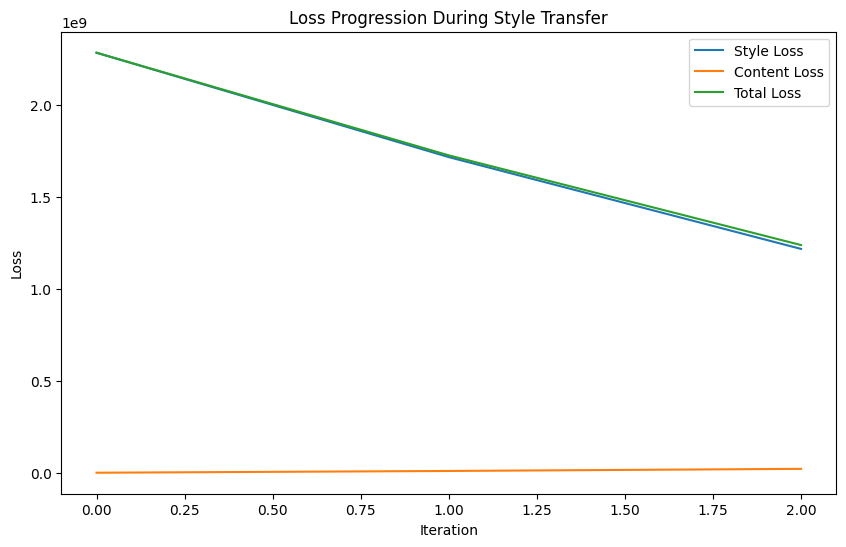

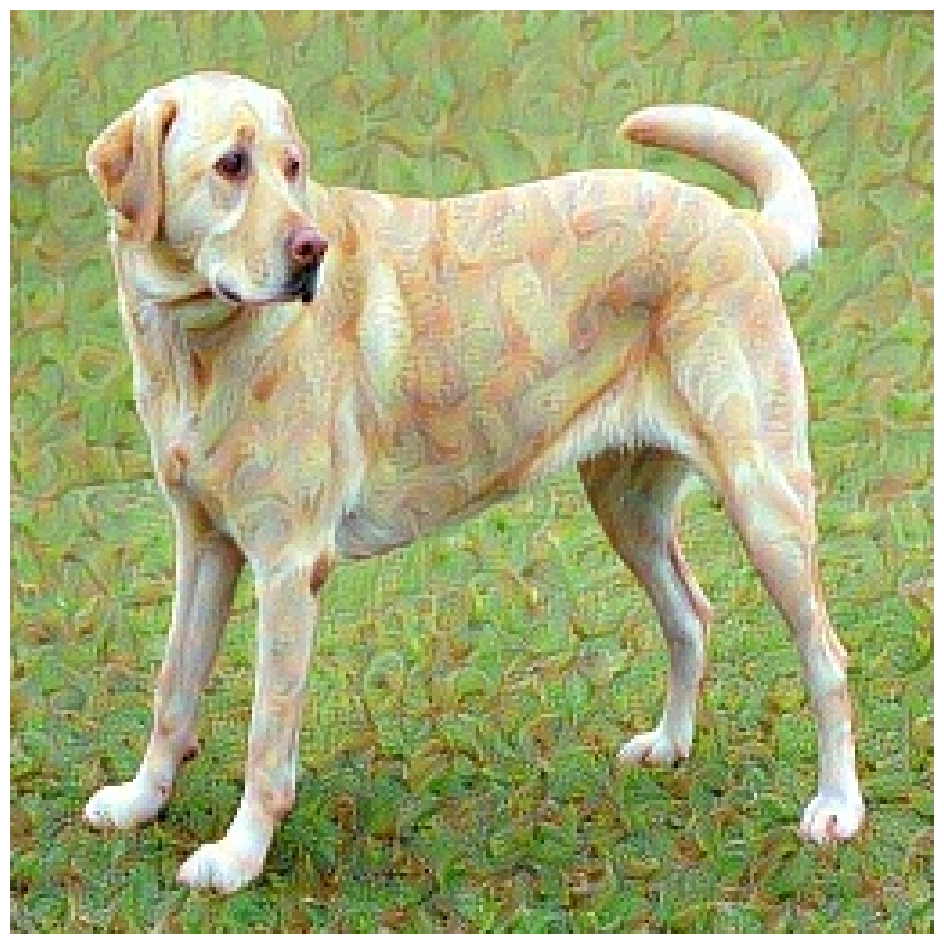

In [175]:
for _ in range(3):
    style_loss, content_loss, total_loss = train_step(image)

    loss_history["style_loss"].append(style_loss.numpy())
    loss_history["content_loss"].append(content_loss.numpy())
    loss_history["total_loss"].append(total_loss.numpy())


plt.figure(figsize=(10, 6))
plt.plot(loss_history["style_loss"], label="Style Loss")
plt.plot(loss_history["content_loss"], label="Content Loss")
plt.plot(loss_history["total_loss"], label="Total Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Progression During Style Transfer")
plt.legend()
plt.show()

final_image = tensor_to_image(image)

final_image_decoded = tf.image.decode_jpeg(final_image)

plt.imshow(final_image_decoded.numpy())
plt.axis('off')
plt.show()


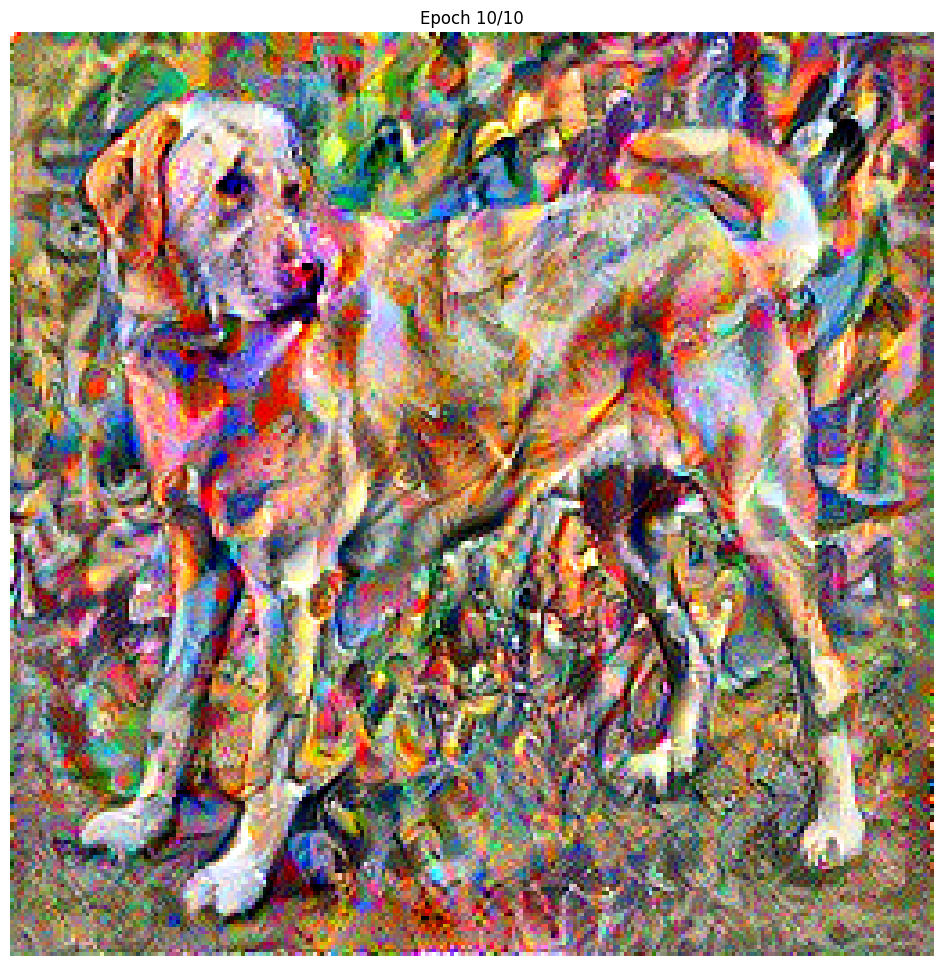

Train step: 1000
Total time: 431.9 seconds


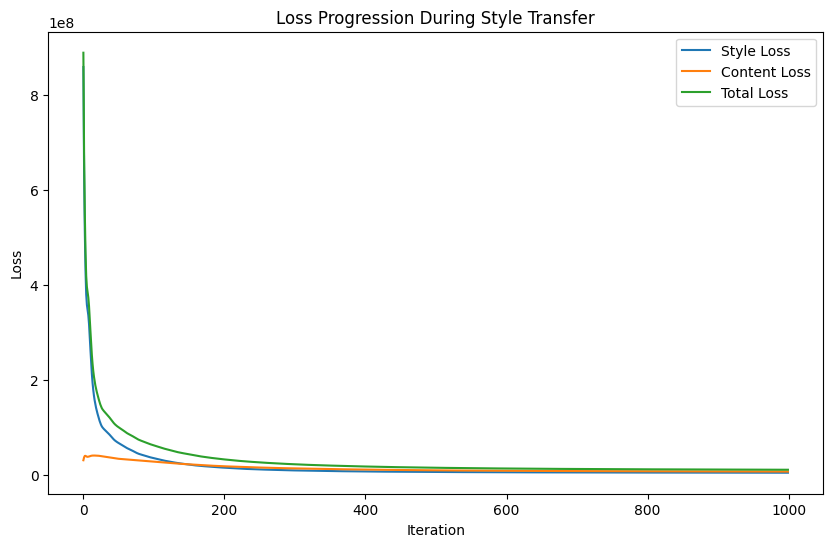

In [176]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0

loss_history = {
    "style_loss": [],
    "content_loss": [],
    "total_loss": []
}

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        
        style_loss, content_loss, total_loss = train_step(image)

        loss_history["style_loss"].append(style_loss.numpy())
        loss_history["content_loss"].append(content_loss.numpy())
        loss_history["total_loss"].append(total_loss.numpy())

        print(".", end='', flush=True)  


    display.clear_output(wait=True)

    plt.imshow(tf.squeeze(image, axis=0).numpy()) 
    plt.axis('off')
    plt.title(f"Epoch {n+1}/{epochs}")
    plt.show()

    print(f"Train step: {step}")

end = time.time()
print(f"Total time: {end - start:.1f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(loss_history["style_loss"], label="Style Loss")
plt.plot(loss_history["content_loss"], label="Content Loss")
plt.plot(loss_history["total_loss"], label="Total Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Progression During Style Transfer")
plt.legend()
plt.show()


### Key Observations

- **Rapid Initial Decrease**:
  - All losses (style, content, and total) exhibit a steep decline during the first few iterations, indicating fast optimization of the generated image.

- **Convergence**:
  - Losses flatten after approximately 200–300 iterations, showing that the optimization process has reached stability, with minimal further improvements.

- **Dominance of Style Loss**:
  - The **style loss** (blue line) starts at a higher value than the **content loss** (orange line) and contributes significantly to the **total loss** (green line).

- **Content Loss Stability**:
  - The **content loss** stabilizes more quickly compared to the style loss, suggesting that the structure of the content image is preserved early in the process.

- **Balanced Total Loss**:
  - The **total loss** (green line) reflects a balanced combination of the style and content losses, decreasing steadily and flattening over time.


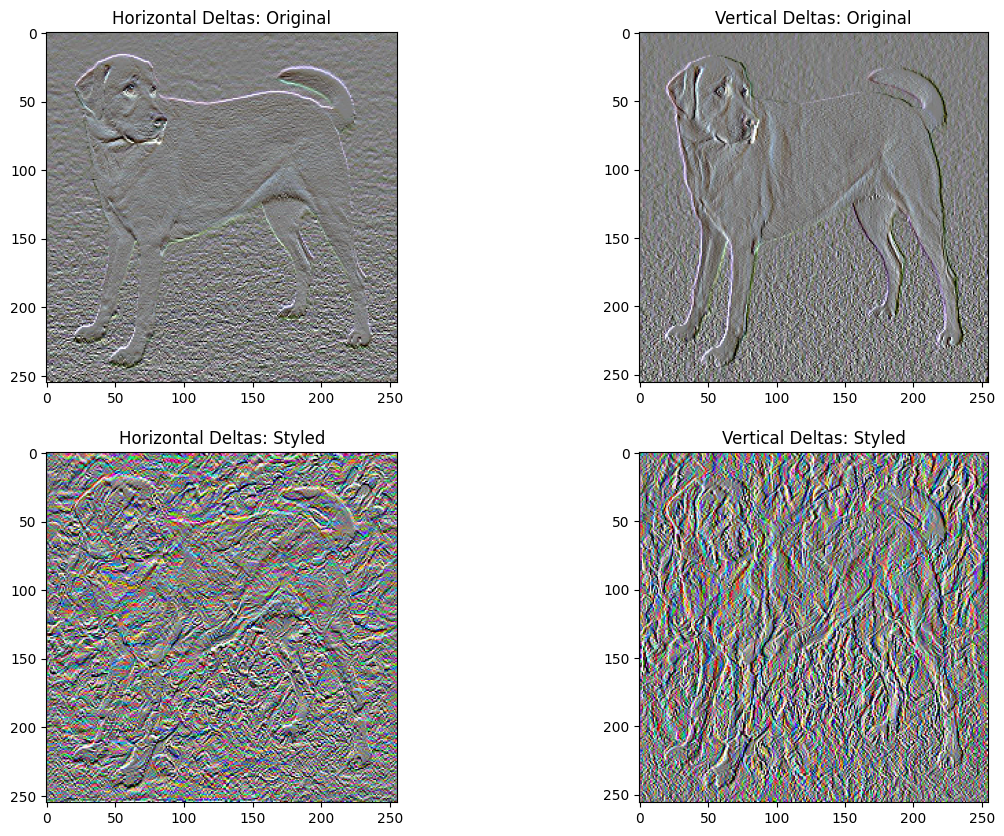

In [177]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

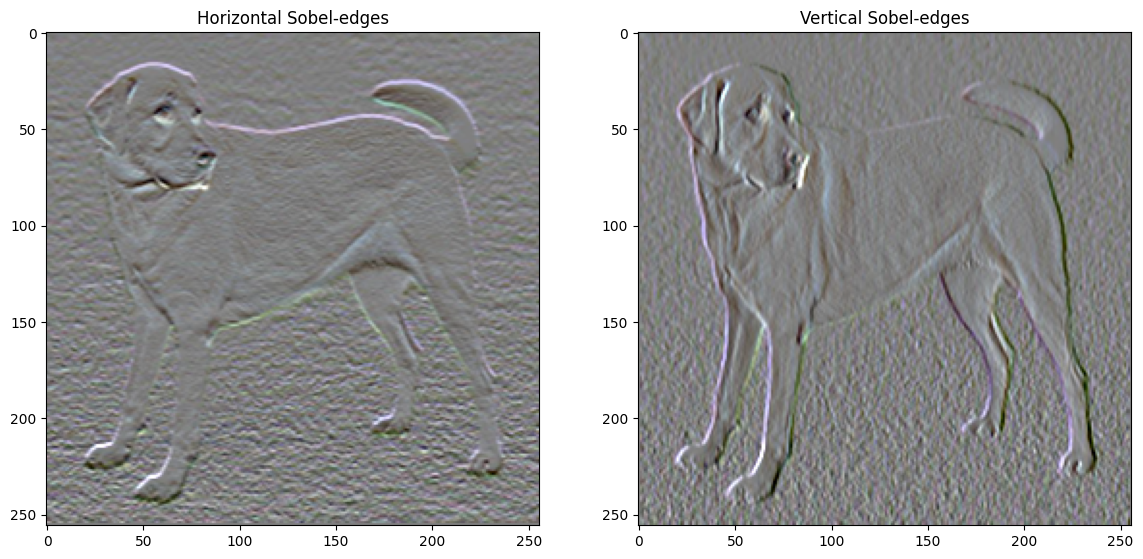

In [178]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The code computes and visualizes Sobel edges and pixel deltas for the content and styled images, highlighting changes in gradients and structure. Sobel edges detect horizontal (left-to-right) and vertical (top-to-bottom) transitions, visualizing the image's structure. Deltas represent changes in pixel values along horizontal and vertical axes. The deltas are calculated for both the original content image and the styled image, showing how gradients evolve during style transfer. Horizontal and vertical deltas are normalized, clipped to [0, 1], and displayed for comparison. Together, these visualizations provide insight into how the style transfer process affects the edges and structure of the image.

In [179]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_weight=30

tv_loss = total_variation_loss(image).numpy()

print(f"Total Variation Loss: {tv_loss:.2f} (Weighted: {tv_loss * total_variation_weight:.2f})")


Total Variation Loss: 53278.79 (Weighted: 1598363.62)


In [180]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)

        style_loss = tf.add_n([
            tf.reduce_mean((outputs['style'][name] - style_targets[name]) ** 2)
            for name in outputs['style'].keys()
        ])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([
            tf.reduce_mean((outputs['content'][name] - content_targets[name]) ** 2)
            for name in outputs['content'].keys()
        ])
        content_loss *= content_weight / num_content_layers

        tv_loss = total_variation_weight * tf.image.total_variation(image)


        total_loss = style_loss + content_loss + tv_loss

    grad = tape.gradient(total_loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


    return style_loss, content_loss, tv_loss, total_loss

In [181]:
def tensor_to_image(tensor):
    tensor = tensor * 255 
    tensor = np.array(tensor, dtype=np.uint8) 
    if tensor.ndim > 3:  
        tensor = tensor[0]
    return Image.fromarray(tensor)

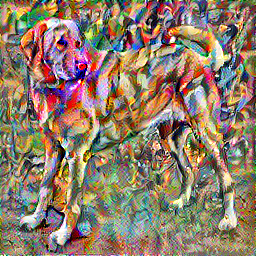

Train step: 1000
Total time: 440.2 seconds


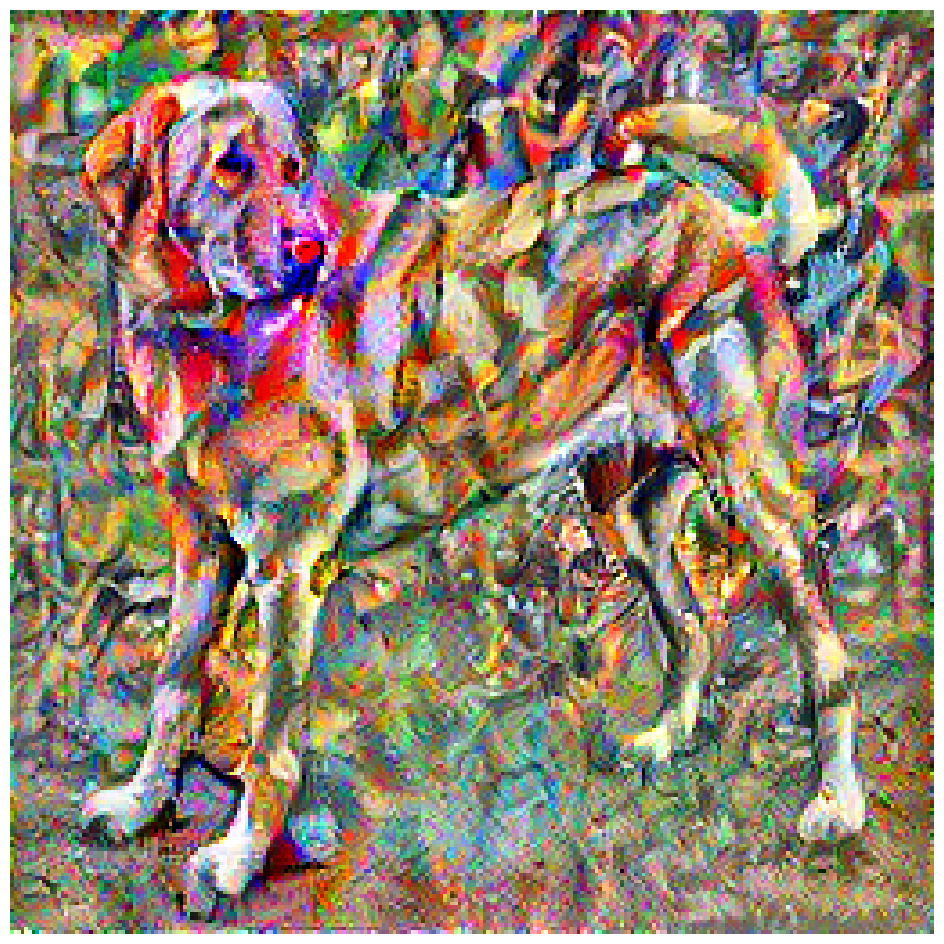

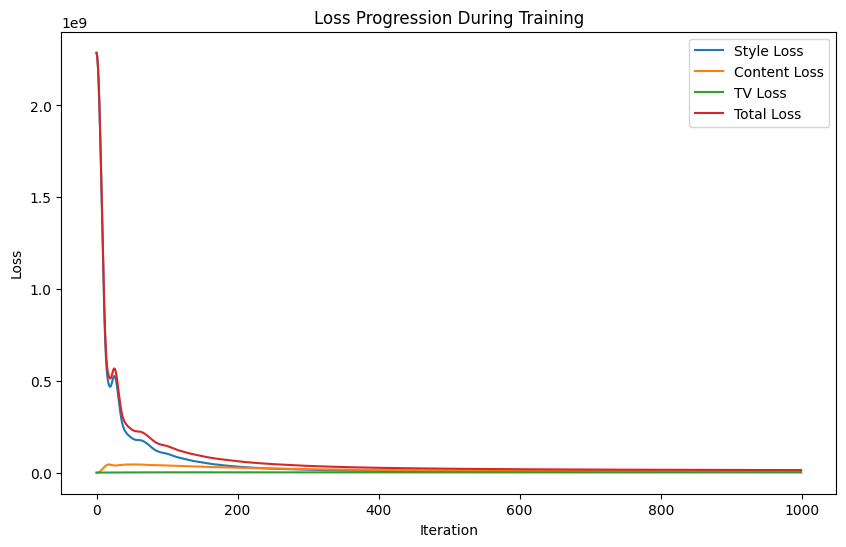

In [ ]:
import io
from PIL import Image 

image = tf.Variable(content_image)

loss_history = {
    "style_loss": [],
    "content_loss": [],
    "tv_loss": [],
    "total_loss": []
}

start = time.time()

epochs = 10
steps_per_epoch = 100
step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        style_loss, content_loss, tv_loss, total_loss = train_step(image)

        loss_history["style_loss"].append(style_loss.numpy())
        loss_history["content_loss"].append(content_loss.numpy())
        loss_history["tv_loss"].append(tv_loss.numpy())
        loss_history["total_loss"].append(total_loss.numpy())

        print(".", end='', flush=True)  

    display.clear_output(wait=True)

    final_image = tensor_to_image(image)  
    pil_image = final_image if isinstance(final_image, Image.Image) else Image.open(io.BytesIO(final_image))

    display.display(pil_image)
    print(f"Train step: {step}")

end = time.time()
print(f"Total time: {end - start:.1f} seconds")

image_squeezed = tf.squeeze(image, axis=0)
plt.imshow(image_squeezed.numpy())
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["style_loss"], label="Style Loss")
plt.plot(loss_history["content_loss"], label="Content Loss")
plt.plot(loss_history["tv_loss"], label="TV Loss")
plt.plot(loss_history["total_loss"], label="Total Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Progression During Training")
plt.legend()
plt.show()


### Key Observations

1. **Initial Rapid Decline**:
   - All losses (**style loss**, **content loss**, and **TV loss**) decrease sharply during the first 200 iterations.
   - This indicates that the optimizer quickly aligns the generated image with the desired style and content features.

2. **Stabilization**:
   - After about 300 iterations, the losses flatten significantly, indicating convergence.
   - Further optimization results in minimal improvements.

3. **Style Loss (Blue)**:
   - The style loss starts high and decreases steadily.
   - It dominates the initial total loss, reflecting the complexity of aligning the generated image with the target style.

4. **Content Loss (Yellow)**:
   - The content loss starts relatively low and stabilizes quickly.
   - This suggests that the structural features of the content image are preserved early in the optimization process.

5. **TV Loss (Green)**:
   - The TV loss remains constant and minimal throughout.
   - This ensures smoothness in the generated image without introducing noise or artifacts.

6. **Total Loss (Red)**:
   - The total loss is the weighted combination of all losses and follows a similar trend.
   - It is dominated by the style loss early in training and converges toward stability.


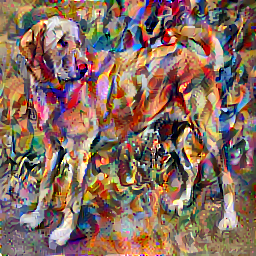

Train step: 5000
Total time: 2191.7 seconds


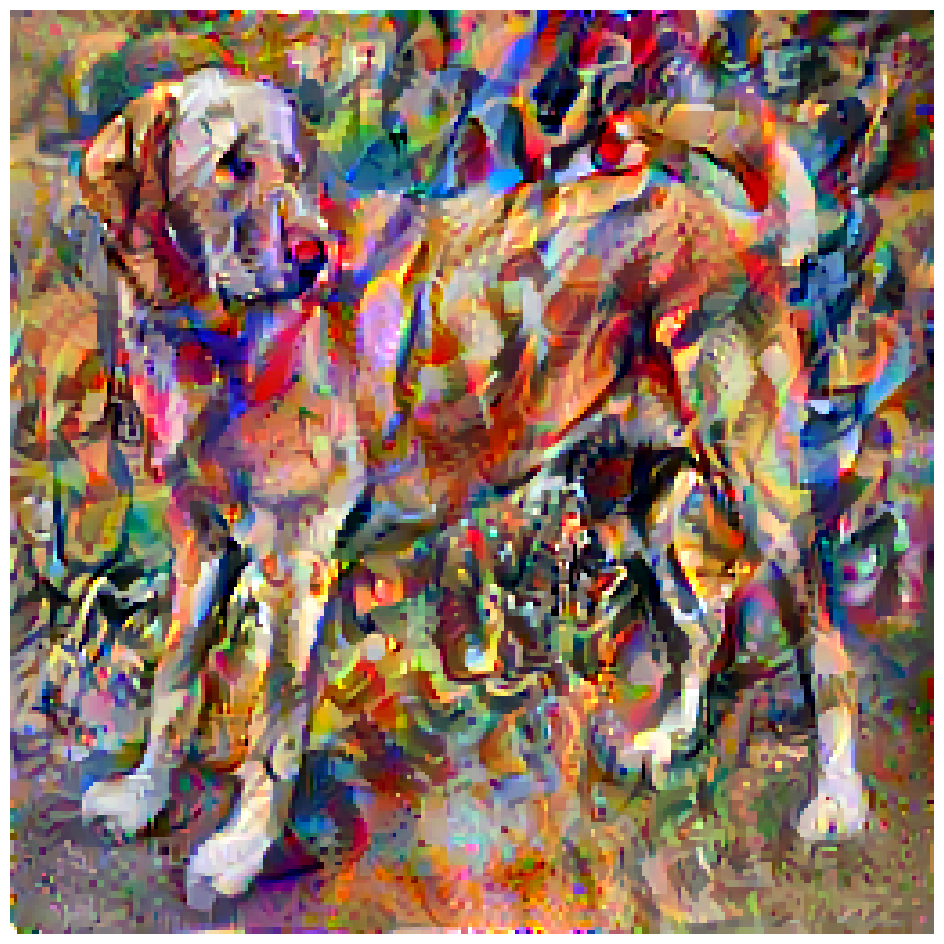

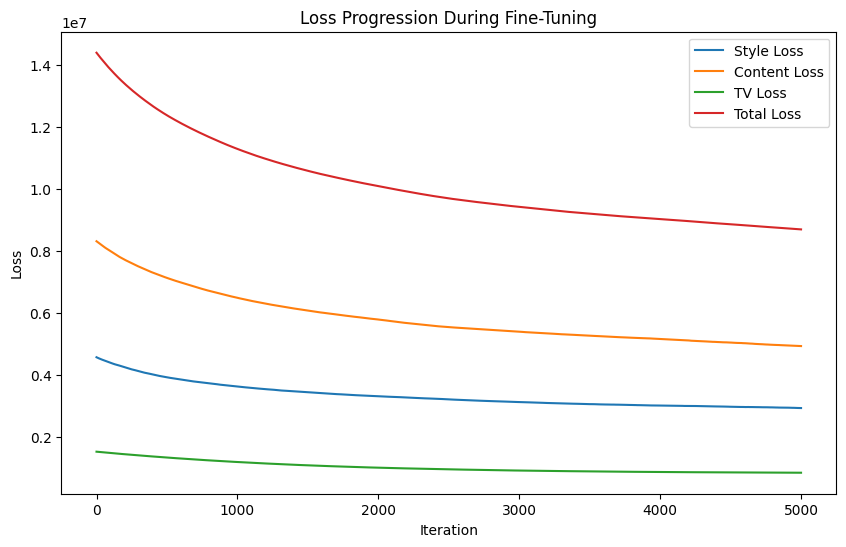

In [187]:
print("Available GPUs:", tf.config.experimental.list_physical_devices('GPU'))

start = time.time()

epochs = 50
steps_per_epoch = 100  
learning_rate = 1e-5 

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)


loss_history = {
    "style_loss": [],
    "content_loss": [],
    "tv_loss": [],
    "total_loss": []
}

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1

        style_loss, content_loss, tv_loss, total_loss = train_step(image)
        
        loss_history["style_loss"].append(style_loss.numpy())
        loss_history["content_loss"].append(content_loss.numpy())
        loss_history["tv_loss"].append(tv_loss.numpy())
        loss_history["total_loss"].append(total_loss.numpy())

        print(".", end='', flush=True)  

    display.clear_output(wait=True)

    final_image = tensor_to_image(image)
    
    pil_image = final_image if isinstance(final_image, PIL.Image.Image) else PIL.Image.open(io.BytesIO(final_image))
    
    display.display(pil_image) 
    print(f"Train step: {step}")  

end = time.time()
print(f"Total time: {end - start:.1f} seconds")


image_squeezed = tf.squeeze(image, axis=0) 
plt.imshow(image_squeezed.numpy()) 
plt.axis('off') 
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["style_loss"], label="Style Loss")
plt.plot(loss_history["content_loss"], label="Content Loss")
plt.plot(loss_history["tv_loss"], label="TV Loss")
plt.plot(loss_history["total_loss"], label="Total Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Progression During Fine-Tuning")
plt.legend()
plt.show()


### Key Observations

1. **Gradual Decline in Losses**:
   - All losses (**style loss**, **content loss**, and **TV loss**) show a consistent and steady decrease throughout the fine-tuning process.
   - This indicates that the optimization process is effectively refining the generated image.

2. **Convergence**:
   - As the number of iterations increases, the curves flatten, particularly after 4000 iterations, suggesting that the optimization is approaching convergence.

3. **Style Loss (Blue)**:
   - The style loss decreases gradually, reflecting consistent alignment of the generated image with the target style.
   - Its slower rate of decline compared to the content loss suggests that style alignment is a more complex optimization process.

4. **Content Loss (Yellow)**:
   - The content loss also decreases steadily but remains higher than the TV loss throughout the process.
   - This indicates that the structural details of the content image are being preserved during fine-tuning.

5. **TV Loss (Green)**:
   - The TV loss remains relatively low and decreases only slightly over time, showing that the smoothness constraint on the image is maintained without significant adjustments.

6. **Total Loss (Red)**:
   - The total loss, as a combination of all other losses, shows a smooth and steady decline.
   - Its trend reflects the contributions of style, content, and TV losses, with style and content dominating the optimization process.

---

### Interpretation
- **Effective Fine-Tuning**:
  - The smooth decline in all losses indicates that the fine-tuning process is efficiently improving the generated image.
  
- **Convergence**:
  - The flattening of the curves suggests diminishing returns beyond 4000 iterations.

- **Balanced Optimization**:
  - The consistent trends across style, content, and TV losses indicate a balanced optimization process, maintaining smoothness while refining style and content alignment.


# Losses in Neural Style Transfer

## 1. Style Loss
- **Purpose**: Measures how well the generated image matches the style of the target style image.
- **Calculation**:
  - Compares the **Gram matrices** of the style features extracted from specific layers of the VGG19 model for the generated and style images.
  - **Formula**:
    \[
    \text{Style Loss} = \sum_{l \in \text{style layers}} \frac{\text{mean}((\text{Generated Gram} - \text{Style Gram})^2)}{\text{Number of Style Layers}}
    \]
- **Weight**: Controlled by `style_weight`.

---

## 2. Content Loss
- **Purpose**: Measures how well the generated image preserves the structure and content of the input content image.
- **Calculation**:
  - Compares the feature maps of specific layers of the VGG19 model for the generated and content images.
  - **Formula**:
    \[
    \text{Content Loss} = \sum_{l \in \text{content layers}} \frac{\text{mean}((\text{Generated Features} - \text{Content Features})^2)}{\text{Number of Content Layers}}
    \]
- **Weight**: Controlled by `content_weight`.

---

## 3. Total Variation (TV) Loss
- **Purpose**: Encourages spatial smoothness in the generated image to reduce noise and artifacts.
- **Calculation**:
  - Computes the total variation by summing the absolute differences between adjacent pixel values in both horizontal and vertical directions.
  - **Formula**:
    \[
    \text{TV Loss} = \sum |\text{Pixel Differences (Horizontal)}| + \sum |\text{Pixel Differences (Vertical)}|
    \]
- **Weight**: Controlled by `total_variation_weight`.

---

## 4. Total Loss
- **Purpose**: Combines the above losses to optimize the image while balancing style, content, and smoothness.
- **Calculation**:
  - Sum of weighted style loss, content loss, and TV loss:
    \[
    \text{Total Loss} = \text{style\_weight} \times \text{Style Loss} + \text{content\_weight} \times \text{Content Loss} + \text{total\_variation\_weight} \times \text{TV Loss}
    \]

---

### Summary of Loss Functions
- **Style Loss**: Captures artistic patterns and textures.
- **Content Loss**: Preserves structural details.
- **TV Loss**: Reduces noise and ensures smoothness.
- **Total Loss**: Balances all losses for optimal image generation.


### Conclusion
The training and fine-tuning processes for neural style transfer effectively optimized the generated image, balancing the target style and content features while maintaining smoothness. Loss trends showed steady convergence, validating the stability of the optimization process and the suitability of chosen hyperparameters.

### Further Work
1. **Hyperparameter Tuning**:
   - Experiment with different values of `style_weight`, `content_weight`, and `total_variation_weight` to achieve a more customized balance between style and content.

2. **Multiple Style Images**:
   - Extend the model to handle style blending using multiple style images, allowing for more creative and diverse outputs.

3. **High-Resolution Outputs**:
   - Adapt the framework to generate high-resolution images through progressive upscaling or advanced models like StyleGAN.
